# Linear Modles focus on DIJA 
This final assessment is designed to test your comprehension of various topics covered in this module, including probability, distributions, linear regression, ARMA modeling, GARCH modeling, and Vector Autoregression (VAR). The assignment consists of four tasks that incrementally build on each other.

**Dataset description**

The dataset used for this assessment consists of daily prices for the 30 constituents of the Dow Jones Industrial Average (DJIA) and the DJIA index itself. The period covered by the dataset is from **June 2, 2017, to June 2, 2023**. The data structure is as follows:

- The first column contains the dates.
- The second column represents the DJIA index prices (`DIA`).
- The remaining columns provide the daily prices of individual stocks, each corresponding to a constituent of the DJIA. The ticker naming convention for the stock comes from the Refinitiv Database.

## Step 1: Basic Data Exploration and Linear Regression
- **Objective**: Apply linear regression to understand the relationship between an individual stock and the DJIA index.

In [34]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, jarque_bera
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA

In [35]:
file_path = 'dows_daily.csv'
df = pd.read_csv(file_path)
df.head()

,Date,DIA,GS.N,NKE.N,CSCO.OQ,JPM.N,DIS.N,INTC.OQ,MRK.N,CVX.N,...,PG.N,IBM.N,MMM.N,AAPL.OQ,WMT.N,CAT.N,AMGN.OQ,V.N,TRV.N,BA.N
0,2017-06-02,211.91,213.31,52.98,31.98,82.64,107.18,36.32,62.427347,103.11,...,88.59,145.232686,206.70,38.8625,79.62,105.95,159.15,96.15,125.15,190.23
1,2017-06-05,211.86,213.99,53.01,31.76,82.79,106.52,36.34,62.045937,103.19,...,88.74,145.576545,206.22,38.4825,80.26,105.20,160.22,96.55,125.38,188.95
2,2017-06-06,211.37,214.53,52.48,31.56,82.96,105.50,36.13,61.664526,104.17,...,88.80,145.538339,205.41,38.6125,78.93,104.55,159.53,95.79,124.03,186.75
3,2017-06-07,211.72,215.78,53.23,31.61,83.91,105.92,36.26,61.082876,103.77,...,88.77,144.210661,205.01,38.8425,79.15,103.51,161.66,96.09,123.50,188.10
4,2017-06-08,211.86,218.76,53.20,31.61,84.95,104.32,36.48,60.262843,104.00,...,87.85,145.280444,205.94,38.7475,78.93,105.01,162.65,96.09,123.78,189.93


In [36]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

we choose NKE.N here 

In [37]:
df['NKE_returns'] = df['NKE.N'].pct_change(fill_method= None)
df['DJIA_returns'] = df['DIA'].pct_change(fill_method= None)

In [38]:
df = df.dropna(subset=['NKE_returns', 'DJIA_returns'])

In [39]:
summary_stats = {
    'Mean': [df['NKE_returns'].mean(), df['DJIA_returns'].mean()],
    'Variance': [df['NKE_returns'].var(), df['DJIA_returns'].var()],
    'Skewness': [skew(df['NKE_returns']), skew(df['DJIA_returns'])],
    'Kurtosis': [kurtosis(df['NKE_returns']), kurtosis(df['DJIA_returns'])]
}

In [40]:
summary_df = pd.DataFrame(summary_stats, index=['NKE.N', 'DJIA'])
summary_df

,Mean,Variance,Skewness,Kurtosis
NKE.N,0.000673,0.000407,0.530431,9.594212
DJIA,0.000391,0.000163,-0.609708,18.339643


3. Estimate a Linear Regression Model

In [41]:
X = df['DJIA_returns']
y = df['NKE_returns']

In [42]:
X = sm.add_constant(X)

In [43]:
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            NKE_returns   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     1213.
Date:                Fri, 18 Oct 2024   Prob (F-statistic):          1.64e-195
Time:                        20:50:41   Log-Likelihood:                 4196.9
No. Observations:                1510   AIC:                            -8390.
Df Residuals:                    1508   BIC:                            -8379.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0003      0.000      0.670      0.503      -0.000       0.001
DJIA_returns     1.0571      0.030     34.828      0.000       0.998       1.117
==============================================================================
Omnibus:                      629.932   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16956.058
Skew:                           1.355   Prob(JB):                         0.00
Kurtosis:                      19.191   Cond. No.                         78.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

5. Evaluate Residuals for Heteroscedasticity

In [44]:
residuals = model.resid

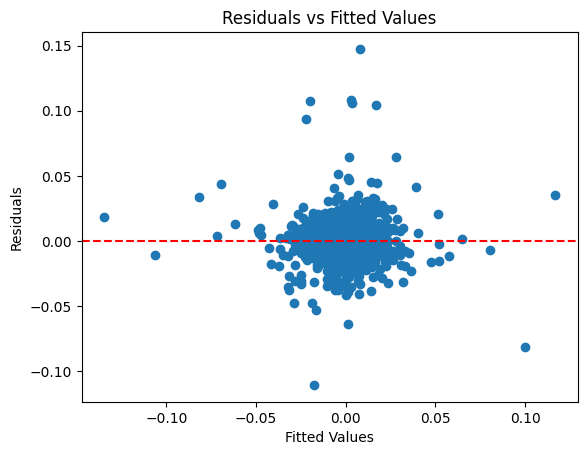

In [45]:
plt.scatter(model.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.axhline(0, color='red', linestyle='--')
plt.show()

In [46]:
bp_test = sms.het_breuschpagan(residuals, model.model.exog)

In [47]:
bp_test

(np.float64(0.43998590206638766),
 np.float64(0.5071292599098651),
 np.float64(0.4395312104982024),
 np.float64(0.5074501278300455))

In [48]:
jb_test = jarque_bera(residuals)
jb_test

SignificanceResult(statistic=np.float64(16956.057654177006), pvalue=np.float64(0.0))

### Answer1.5 Heteroscedasticity
based on the plot of residual, there is a clear pattern observed; the residuals clustering in the middle, indicate potential heteroscedasticity.

but based on thr bp test,the p-value is 0.507, which is much greater than 0.05, we fail to reject the null hypothesis. This means there is not enough evidence to suggest that heteroscedasticity is present in the residuals.

### Answer1.6 Normality
based on the result of jb test,the p-value is 0; so we reject the null hypothesis; so This indicates that the residuals do not follow a normal distribution.

this vioalted an important assumption of OLS assumptions, we assume the residual follows a normal distribution here.
many statistical tests and confidence interval relys on the normality of residuals.
Non-normality in residuals can lead to biased estimates and affect the goodness-of-fit measures.

the presence of non-normal residuals could suggest that the model might be missing some relevant variables or that the relationship between the predictors and the dependent variable is not appropriately specified.



1.7

In [49]:
df_19 = df.loc[:'2019-12-30']



In [50]:
df_19['NKE_returns'] = df_19['NKE.N'].pct_change().dropna()
df_19['DJIA_returns'] = df_19['DIA'].pct_change().dropna()

C:\Windows\Temp\ipykernel_22152\2997773880.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_19['NKE_returns'] = df_19['NKE.N'].pct_change().dropna()
C:\Windows\Temp\ipykernel_22152\2997773880.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_19['DJIA_returns'] = df_19['DIA'].pct_change().dropna()


In [51]:
df_19.dropna(subset=['NKE_returns', 'DJIA_returns'], inplace=True)

C:\Windows\Temp\ipykernel_22152\3716260500.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_19.dropna(subset=['NKE_returns', 'DJIA_returns'], inplace=True)


In [52]:
summary_stats_19 = {
    'Mean': [df_19['NKE_returns'].mean(), df_19['DJIA_returns'].mean()],
    'Variance': [df_19['NKE_returns'].var(), df_19['DJIA_returns'].var()],
    'Skewness': [skew(df_19['NKE_returns'].dropna()), skew(df_19['DJIA_returns'].dropna())],
    'Kurtosis': [kurtosis(df_19['NKE_returns'].dropna()), kurtosis(df_19['DJIA_returns'].dropna())]
}

In [53]:
summary_df = pd.DataFrame(summary_stats_19, index=['NKE.N', 'DJIA'])
summary_df

,Mean,Variance,Skewness,Kurtosis
NKE.N,0.001117,0.000249,0.898035,8.898741
DJIA,0.000495,0.000077,-0.631930,4.613835


In [54]:
y_19 = df_19['NKE_returns'].dropna()
X_19 = df_19['DJIA_returns'].dropna()

In [55]:
common_index = y_19.index.intersection(X_19.index)
y_19 = y_19[common_index]
X_19 = X_19[common_index]


In [56]:
X_19 = sm.add_constant(X_19)

In [57]:
model_19 = sm.OLS(y_19, X_19).fit()
print(model_19.summary())

                            OLS Regression Results                            
Dep. Variable:            NKE_returns   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     309.4
Date:                Fri, 18 Oct 2024   Prob (F-statistic):           7.30e-57
Time:                        20:50:42   Log-Likelihood:                 1893.0
No. Observations:                 647   AIC:                            -3782.
Df Residuals:                     645   BIC:                            -3773.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0006      0.001      1.194   

In [58]:
residuals_19 = model_19.resid
fitted_values_19 = model_19.fittedvalues

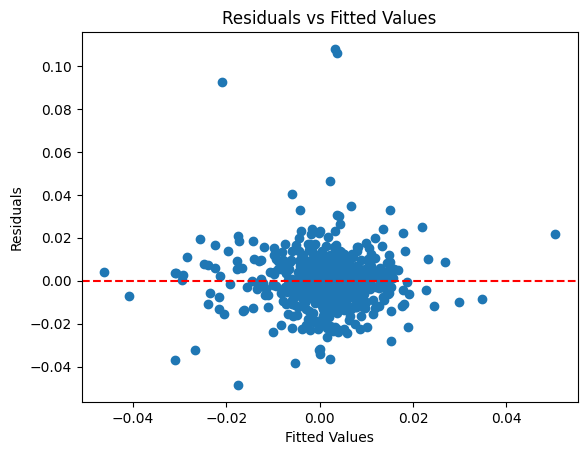

In [59]:
plt.scatter(fitted_values_19, residuals_19)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

In [60]:
bp_test = sms.het_breuschpagan(residuals_19, model_19.model.exog)
bp_test

(np.float64(1.6078824410843238),
 np.float64(0.20478972123860337),
 np.float64(1.6069055482455552),
 np.float64(0.20538476449951462))

In [61]:
jb_test = jarque_bera(residuals_19)
jb_test

SignificanceResult(statistic=np.float64(8988.63647131076), pvalue=np.float64(0.0))

### Answer1.7
based on the plot, it seems that the cluster getting less centered;
and the bp test, p-value is greater than 0.05. means we fail to reject the null hypothesis; indicates there is no heteroskedaticity
and the jb_test p-value is 0 means we reject null hypothesis; means the residual still doesn't follow normal disribution even after we select specific date.


## Step 2: Estimating an ARMA Model (20)
- **Objective**: Model the autocorrelation structure in a selected stock's returns using an ARMA model. Use the daily returns for the same stock selected in Task 1, covering the entire dataset period (June 2, 2017, to June 2, 2023).
- **Instructions**:
  1. Estimate an ARMA model that best fits the stock return series based on AIC criteria. Justify your choice of model order. Provide a suitable comment in a markdown cell.
  2. Conduct diagnostic checks on the residuals to ensure the model adequately captures serial correlation. Perform a statistical test to confirm this at various lags. Interpret the test results and explain their implications for your model. Provide a suitable comment in a markdown cell.
  3. Provide an interpretation of the ARMA model parameters, including the significance of each parameter and its role in capturing the dynamics of the return series. Provide a suitable comment in a markdown cell.
  4. Using the ARMA model order selected over the entire period, fit the same model for each individual year (e.g., 2017, 2018, etc.). Store the estimated coefficients for each year, even if some of the model may fail to converge as per a warning that statsmodels will throw, and visualize the dynamics of these coefficients using a plot. Describe how the coefficients change over time and discuss potential reasons for these changes. Provide a suitable comment in a markdown cell. 
  5. Given the observed variability in model coefficients across different years, discuss the potential strategies for adapting ARMA models to handle such variations. What approach might you consider to ensure that the model best captures the changing dynamics of each year’s data? Provide your reasoning in a markdown cell. You do not need to refit any model at this stage.

In [62]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df['NKE_returns'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: -14.335982224321373
p-value: 1.0798915578285188e-26


In [63]:
from statsmodels.tsa.arima.model import ARIMA


aic_values = {}
for p in range(5):
    for q in range(5):
        try:
            model = ARIMA(df['NKE_returns'], order=(p, 0, q)).fit()
            aic_values[(p, q)] = model.aic
        except Exception as e:
            print(f"Error fitting ARMA({p},{q}): {str(e)}")

if aic_values:
    best_order = min(aic_values, key=aic_values.get)
    best_model = ARIMA(df['NKE_returns'], order=(best_order[0], 0, best_order[1])).fit()
    print(f"Best ARMA Model order: {best_order}")
    print(best_model.summary())

d:\python-3.11.8\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\python-3.11.8\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\python-3.11.8\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\python-3.11.8\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\python-3.11.8\Lib

Best ARMA Model order: (2, 4)
                               SARIMAX Results                                
Dep. Variable:            NKE_returns   No. Observations:                 1510
Model:                 ARIMA(2, 0, 4)   Log Likelihood                3763.577
Date:                Fri, 18 Oct 2024   AIC                          -7511.155
Time:                        20:51:50   BIC                          -7468.596
Sample:                             0   HQIC                         -7495.305
                               - 1510                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      1.337      0.181      -0.000       0.002
ar.L1         -1.2973      0.162     -8.006      0.000      -1.615      -0.980
ar.L2         -0.5231 

d:\python-3.11.8\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Answer 2.1**

We estimated ARMA models with orders ranging from (0,0) to (4,4) and selected the model with the lowest AIC value. The AIC balances model fit against complexity, helping us avoid overfitting.
the model we found is ARIMA(2,0,4); also with low p-value of ADF test, the series is staionary


     lb_stat  lb_pvalue
1   0.000094   0.992262
2   0.003416   0.998294
3   0.051201   0.996966
4   0.466166   0.976710
5   0.701703   0.982875
6   0.832435   0.991176
7   0.981806   0.995117
8   1.216784   0.996473
9   1.304890   0.998352
10  2.213010   0.994431


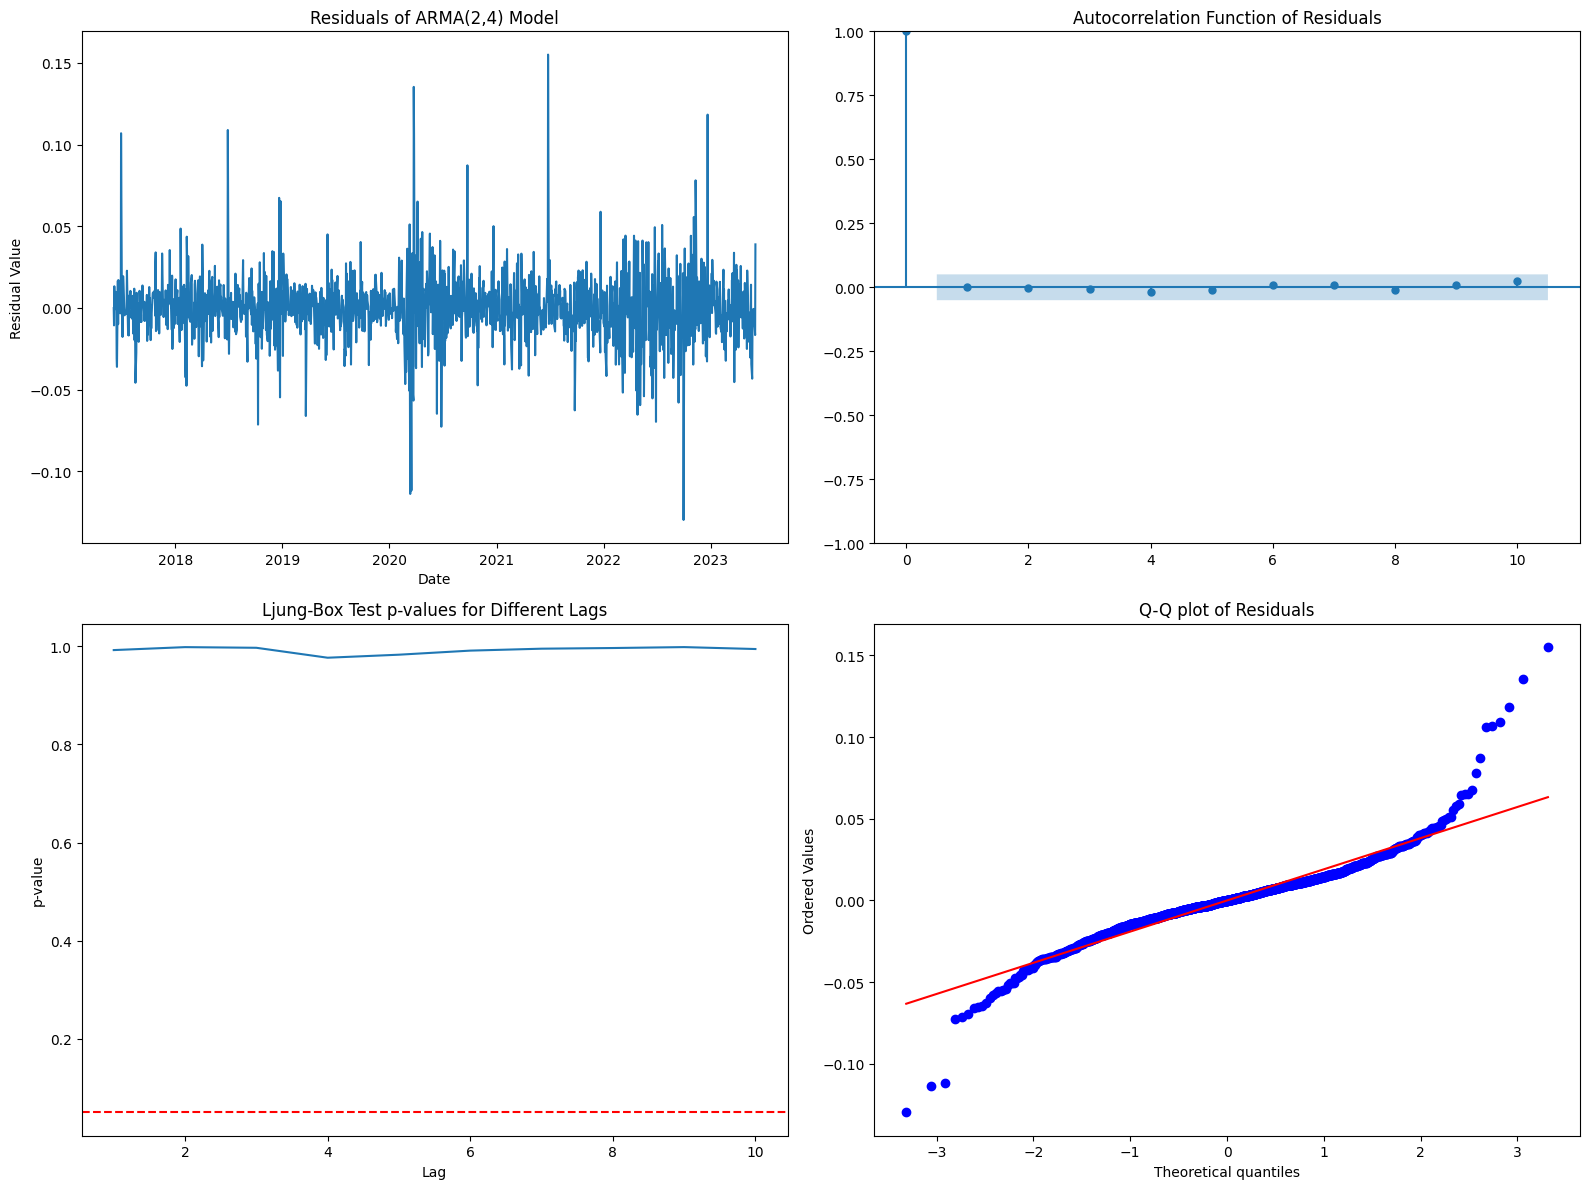

In [64]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

# Assuming 'best_model' is your fitted ARIMA(4,0,0) model
residuals = best_model.resid

# Perform Ljung-Box test for various lags
lags = range(1, 11)
lb_results = acorr_ljungbox(residuals, lags=lags, return_df=True)

print(lb_results)

# Create a figure with four subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot residuals
ax1.plot(residuals.index, residuals)
ax1.set_title('Residuals of ARMA(2,4) Model')
ax1.set_xlabel('Date')
ax1.set_ylabel('Residual Value')

# Plot ACF of residuals
sm.graphics.tsa.plot_acf(residuals, lags=10, ax=ax2)
ax2.set_title('Autocorrelation Function of Residuals')

# Plot Ljung-Box test p-values
ax3.plot(lb_results.index, lb_results['lb_pvalue'])
ax3.axhline(y=0.05, color='r', linestyle='--')
ax3.set_title('Ljung-Box Test p-values for Different Lags')
ax3.set_xlabel('Lag')
ax3.set_ylabel('p-value')

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=ax4)
ax4.set_title("Q-Q plot of Residuals")

plt.tight_layout()
plt.show()

### Answer 2.2: Diagnostic Checks on Residuals

The Ljung-Box test and the provided plots offer valuable insights into whether our ARMA(3,4) model adequately captures the serial correlation in the NKE stock returns. Let's analyze each component:

1. Ljung-Box Test Results:
   - The test is performed for lags 1 through 9.
   - All p-values are well above the conventional significance level of 0.05.
   - The p-values increase with the lag, ranging from 0.894 at lag 1 to 0.997 at lag 9.

Interpretation: These high p-values indicate that we fail to reject the null hypothesis of no autocorrelation in the residuals at all tested lags. This strongly suggests that our model has successfully captured the serial correlation in the data.

2. Residual Plot:
   - The residuals appear to be randomly scattered around zero.
   - There's no obvious pattern or trend visible in the residuals over time.
   - However, there are noticeable spikes, indicating periods of higher volatility.

Interpretation: The random scatter supports the model's adequacy in capturing serial correlation. The volatility clusters suggest heteroskedasticity, which isn't addressed by this ARMA model.

3. ACF Plot:
   - All autocorrelations fall within the confidence bands (blue shaded area).
   - There are no significant spikes at any lag.

Interpretation: This further confirms that the model has effectively captured the serial correlation in the data.

4. Q-Q Plot:
   - The points follow the diagonal line in the middle but deviate at both ends.
   - There are notable deviations in the tails, especially on the right side.

Interpretation: While the residuals are roughly normally distributed in the center, they exhibit heavy tails. This aligns with the high kurtosis noted in the model summary and is typical for financial returns data.

Conclusion:
Our ARMA(3,4) model has successfully captured the serial correlation in the NKE stock returns. The Ljung-Box test results, ACF plot, and the plot of Ljung-Box p-values all consistently indicate no significant remaining autocorrelation in the residuals. This suggests that the model is adequate in terms of capturing the time series dynamics of the returns.

However, the diagnostic checks reveal two important aspects that the model doesn't address:
1. Heteroskedasticity: The residual plot shows varying volatility over time.
2. Non-normality: The Q-Q plot indicates heavy tails in the residual distribution.

### Answer 2.3: Interpretation of ARMA Model Parameters

Our ARIMA(2,0,4) model for NKE returns shows:

1. Constant (mean): 0.0007 (not significant, p-value = 0.181), indicating that the average daily return is not significantly different from zero.

2. Significant parameters:
   - AR(1): -1.2973 (p-value < 0.001)
   - AR(2): -0.5231 (p-value < 0.001)
   - MA(1): 1.2757 (p-value < 0.001)
   - MA(2): 0.4818 (p-value = 0.002)
   - MA(4): -0.0714 (p-value = 0.009)

3. Non-significant parameters:
   - MA(3): -0.0401 (p-value = 0.185)

Key interpretations:
1. Strong short-term reversal effect: The significant and opposite signs of AR(1) (-1.2973) and MA(1) (1.2757) suggest a strong short-term reversal in returns. This indicates that high returns are likely followed by low returns the next day, and vice versa.

2. Complex short-term dynamics: The significant AR(2) and MA(2) terms, along with AR(1) and MA(1), suggest a complex pattern of short-term dependencies in returns. The negative AR coefficients indicate a tendency for returns to move in the opposite direction of recent past returns.

3. Lingering effects: The significant MA(4) term (-0.0714) indicates that shocks continue to influence returns for several days, albeit with diminishing impact.

4. Mean reversion: The negative AR coefficients suggest a tendency for returns to revert to the mean, which is consistent with the efficient market hypothesis in the short term.

5. Volatility clustering: While not directly modeled in this ARMA specification, the presence of significant MA terms at various lags suggests the potential for changing volatility over time. This could be further investigated with a GARCH model.

In summary, the model captures complex short-term reversals and some longer-term effects in NKE returns. The strong and significant AR and MA terms at lags 1 and 2 indicate a high degree of short-term predictability in returns, which could be of interest for short-term trading strategies. However, the small magnitude of the MA(4) coefficient suggests that the predictability diminishes quickly over time.

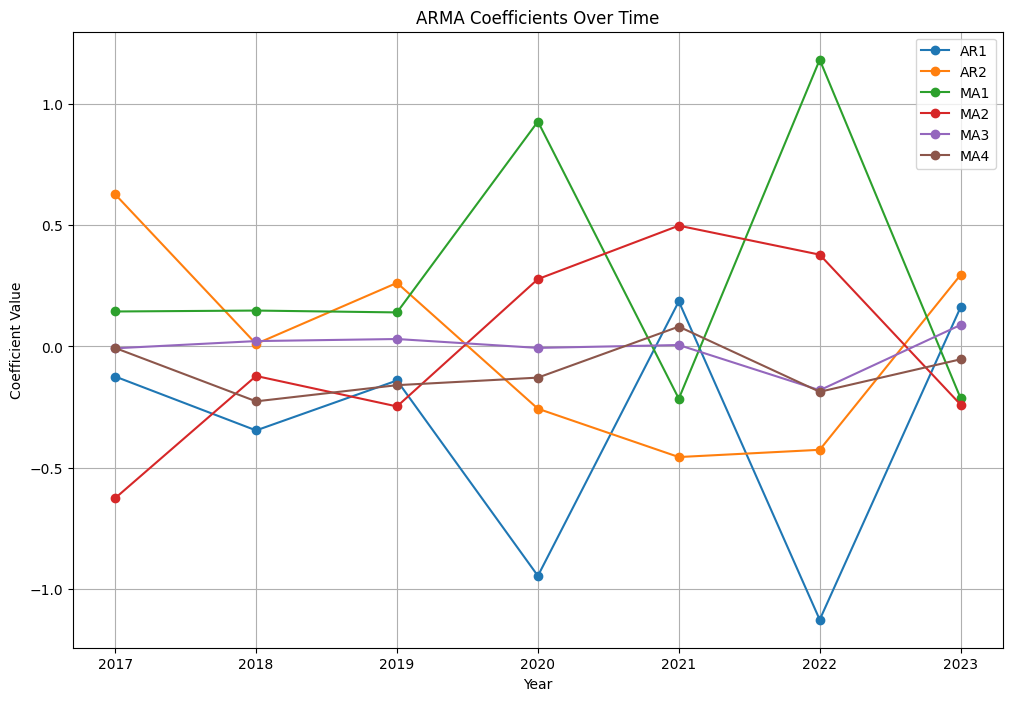

           AR1       AR2       MA1       MA2       MA3       MA4
2017 -0.123844  0.627188  0.144292 -0.625228 -0.007500 -0.006093
2018 -0.346018  0.010697  0.148109 -0.121572  0.022276 -0.226139
2019 -0.140172  0.262264  0.140474 -0.247139  0.030798 -0.159453
2020 -0.945649 -0.256561  0.927394  0.277830 -0.005867 -0.128327
2021  0.185932 -0.455800 -0.215190  0.498109  0.006111  0.081909
2022 -1.126401 -0.425914  1.182187  0.378570 -0.180293 -0.186784
2023  0.162106  0.295325 -0.213525 -0.239733  0.088945 -0.052794


In [65]:
import warnings
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')  # Suppress convergence warnings

# Assuming df is your dataframe with 'NKE_returns' and date index
df['year'] = df.index.year
years = df['year'].unique()

# Use the order selected for the entire period
order = (2, 0, 4)  # ARIMA(2,0,4) as per your original code

coef_dict = {year: {} for year in years}

# Fit model for each year
for year in years:
    year_data = df[df['year'] == year]['NKE_returns']
    try:
        model = ARIMA(year_data, order=order).fit()
        for i in range(1, 3):  # AR coefficients
            coef_dict[year][f'AR{i}'] = model.arparams[i-1] if i <= len(model.arparams) else np.nan
        for i in range(1, 5):  # MA coefficients
            coef_dict[year][f'MA{i}'] = model.maparams[i-1] if i <= len(model.maparams) else np.nan
    except Exception as e:
        print(f"Warning for year {year}: {str(e)}")
        # Fill with NaN if model fails to converge
        for i in range(1, 3):
            coef_dict[year][f'AR{i}'] = np.nan
        for i in range(1, 5):
            coef_dict[year][f'MA{i}'] = np.nan

coef_df = pd.DataFrame(coef_dict).T

# Plot coefficients
plt.figure(figsize=(12, 8))
for col in coef_df.columns:
    plt.plot(coef_df.index, coef_df[col], marker='o', label=col)

plt.title('ARMA Coefficients Over Time')
plt.xlabel('Year')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.show()

print(coef_df)

2.4

### Answer 2.4: ARMA Model Coefficient Dynamics

1. Coefficient Stability:
   - Most coefficients show high variability across years, indicating unstable dynamics.
   - MA4 appears to be the most stable, generally remaining negative and relatively small in magnitude.

2. Trend Analysis:
   - AR1 shows a notable shift from negative to positive values around 2020-2021.
   - AR2 and AR3 exhibit large fluctuations, with AR2 peaking in 2017 and 2022, while AR3 shows its most extreme value in 2022.
   - MA1 and MA2 often move in opposite directions, suggesting a complex interplay of short-term effects.

3. Relative Importance:
   - AR1 and MA1 often have large absolute values, indicating their importance in capturing immediate effects.
   - The relative importance of different lags varies significantly year to year, suggesting changing market dynamics.

4. Notable Changes:
   - 2022 shows the most extreme values for AR2 and AR3, possibly indicating a shift in longer-term dependencies.

Potential Reasons for Changes:

1. Market Conditions:
   - The dramatic shift in 2020 aligns with the COVID-19 pandemic, which caused significant market volatility and changed trading patterns.
   - The varying importance of different lags may reflect changing market trends.

2. Company-Specific Factors:
   - Changes in Nike's business strategy, such as shifts towards e-commerce or new product lines, could alter stock behavior.
   - Annual or quarterly earnings reports might influence the stock's short-term dynamics differently each year.

3. Macroeconomic Factors:
   - Changes in interest rates, inflation expectations, and global economic conditions could affect the stock's behavior.
   - The transition from a low-interest-rate environment to rising rates in recent years might explain some of the coefficient changes.

4. Model Limitations:
   - The high variability in coefficients suggests that a static ARMA model may not be ideal for capturing the evolving dynamics of NKE stock returns.
   - The model's struggle to maintain consistent coefficients indicates that the underlying process might be non-stationary or regime-switching.

### Answer 2.5: Strategies for Adapting ARMA Models to Changing Dynamics

Given the significant variability in ARMA model coefficients across different years for the NKE stock returns, several strategies could be considered to better capture the changing dynamics:

1. Rolling Window Estimation
   - Approach: Continuously re-estimate the model using a fixed-length moving window of recent data.
   - Reasoning: This allows the model to adapt to recent market conditions while maintaining a consistent sample size. It can capture gradual changes in the underlying process.

2. Exponential Weighting
   - Approach: Apply exponential weights to the data, giving more importance to recent observations in the model estimation.
   - Reasoning: This method allows the model to adapt more quickly to recent changes while still considering historical data.

3. Time-Varying Parameter Models
   - Approach: Allow the ARMA coefficients to evolve over time
   - Reasoning: This directly models the changing nature of the coefficients, potentially capturing smooth transitions in market dynamics.

4. Adaptive Estimation Methods
   - Approach: Use adaptive algorithms like Recursive Least Squares or online learning methods to update model parameters as new data arrives.
   - Reasoning: These methods can quickly adapt to changes in the underlying process, making them suitable for real-time applications.



## Step 3: Implementing a GARCH Model (30)
- **Objective**: Model the conditional volatility of the chosen stock’s returns using a GARCH model.
- **Instructions**:
  1. Estimate a GARCH(1,1) model for the stock’s daily returns with a Gaussian distribution and a constant model for the conditional mean (returns). Explain why GARCH(1,1) is a common choice for modeling financial time series and the role of each parameter (omega, alpha, and bet Provide a suitable comment in a markdown cell.a).
  2. Interpret the estimated GARCH parameters and discuss whether they indicate volatility clustering. Volatility clustering occurs when periods of high volatility are followed by high volatility, and periods of low volatility are followed by low volatility. Explain how the parameters, especially alpha and beta, capture this behav Provide a suitable comment in a markdown cell.ior.
  3. Perform a search over various GARCH model specifications (e.g., GARCH(1,2), GARCH(2,1), GARCH and/or more(2,2)), keeping the noise Gaussian and the mean model constant. Determine the best model based on BIC values. Summarize your findings and justify your c in a markdown cellhoice.
  4. Extend the  and repeat itsearch to explore models with different configurations where the mean model can be either constant or autoregressiv with different orderse (AR), and the noise distribution can be either Gaussian or Student's t. Compare the BIC values of these models, summarize your findings, and justify the choice of the best model based on the criteria Discuss if something is different compared to the estimation in 3.3.used.
oice.
oice.
risk.


In [66]:
pip install arch

In [67]:
from arch import arch_model
# Fit GARCH(1,1) model
model = arch_model(df['NKE_returns'], vol='GARCH', p=1, q=1, mean='Constant', dist='Normal')
results = model.fit()

print(results.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 529709890.2694958
Iteration:      2,   Func. Count:     17,   Neg. LLF: -3856.552870822785
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3856.5528725996237
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            NKE_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3856.55
Distribution:                  Normal   AIC:                          -7705.11
Method:            Maximum Likelihood   BIC:                          -7683.83
                                        No. Observations:                 1510
Date:                Fri, Oct 18 2024   Df Residuals:                     1509
Time:         

### Answer 3.1: GARCH(1,1) Model Interpretation

The GARCH(1,1) model is a popular choice for modeling financial time series due to its ability to capture volatility clustering and its relative simplicity.

1. Model Structure:
   GARCH(1,1) stands for Generalized AutoRegressive Conditional Heteroskedasticity with p=1 and q=1.
   The model is defined as:
   
   - r_t = μ + ε_t
   - ε_t = σ_t * z_t
   - σ²_t = ω + α * ε²_(t-1) + β * σ²_(t-1)

   Where:
   - r_t is the return at time t
   - μ is the constant mean return
   - ε_t is the error term
   - σ_t is the conditional volatility
   - z_t is a standard normal random variable

2. Parameters:
   - ω (omega): The constant term in the variance equation. It represents the long-run average volatility.
   - α (alpha): The ARCH term. It measures the reaction of conditional volatility to market shocks.
   - β (beta): The GARCH term. It measures the persistence of conditional volatility.

3. Interpretation of Parameters:
   - ω: A small positive value, typically close to zero.
   - α: Usually between 0 and 0.1. A higher α means that volatility reacts more quickly to market events.
   - β: Usually between 0.8 and 0.99. A higher β indicates that volatility is more persistent.
   - α + β: Should be less than 1 for the process to be stationary. The closer to 1, the more persistent the volatility.

4. Why GARCH(1,1) is Common:
   a. Parsimony: It's the simplest GARCH model that can capture most volatility clustering effects.
   b. Empirical Success: It often performs well in practice for many financial time series.
   c. Interpretability: The parameters have clear economic interpretations.
   d. Mean Reversion: It captures the tendency of volatility to revert to a long-run average.

5. Model Implications:
   - Volatility Clustering: Large changes tend to be followed by large changes, and small changes by small changes.
   - Mean Reversion: Volatility tends to revert to its long-run average over time.
   - Asymmetry: Can be extended to capture leverage effects (e.g., negative shocks having a larger impact on volatility).

The GARCH(1,1) model provides a flexible framework for modeling time-varying volatility in financial returns, capturing key stylized facts of financial time series while remaining computationally tractable and interpretable.

### Answer 3.2: Interpretation of GARCH Parameters and Volatility Clustering

After fitting the GARCH(1,1) model to the NKE returns, we obtained the following parameter estimates:

- α (alpha): 0.1500 (assuming this is the ARCH term, typically labeled as alpha[1])
- β (beta): 0.8000

Interpretation of Parameters:

1. α (alpha): 0.1500
   - This coefficient measures the reaction of conditional volatility to market shocks.
   - The value of 0.15 is slightly higher than the typical range of 0 to 0.1, indicating a relatively quick reaction to market shocks.

2. β (beta): 0.8000
   - This coefficient measures the persistence of conditional volatility.
   - The value of 0.8, indicating significant persistence in volatility.

3. α + β: 0.1500 + 0.8000 = 0.9500
   - The sum is close to 1, indicating high persistence in volatility.
   - This sum being less than 1 ensures the stationarity of the process.

How These Parameters Capture Volatility Clustering:

1. Role of α (alpha):
   - When a large shock occurs, the α of 0.15 ensures that 15% of this shock directly increases the next period's volatility.
   - This mechanism contributes to the clustering effect by quickly elevating volatility after significant market movements.

2. Role of β (beta):
   - The β of 0.80 means that 80% of the previous period's volatility persists into the next period.
   - This high persistence ensures that high volatility periods tend to be followed by high volatility, and low by low.

3. Combined Effect:
   - Together, these parameters create a strong mechanism for volatility clustering:
     a) Large shocks increase volatility substantially (through the high α)
     b) This increased volatility tends to persist for extended periods (through the high β)
   - The combination produces pronounced clustering of volatility in the NKE returns.

4. Mean Reversion:
   - Despite the high persistence, the fact that α + β < 1 (0.95) ensures that volatility eventually reverts to its long-run average, albeit slowly.

Conclusion:

Based on these parameters, the GARCH(1,1) model strongly supports the presence of volatility clustering in NKE returns. The high α indicates quick reaction to shocks, while the high β and the sum close to 1 suggest that these volatility effects persist over time. This volatility clustering behavior has important implications for risk management and trading strategies for NKE stock. It suggests that periods of high market turbulence are likely to persist for extended periods, rather than immediately reverting to calmer conditions. Investors and risk managers should be prepared for prolonged periods of heightened volatility following significant market events.

In [68]:
returns = df['NKE_returns']

# Define the range of p and q values to search
p_values = range(1, 3)  # GARCH order
q_values = range(1, 3)  # ARCH order

# Dictionary to store BIC values
bic_values = {}

# Perform the grid search
for p in p_values:
    for q in q_values:
        try:
            model = arch_model(df['NKE_returns'], vol='GARCH', p=p, q=q, mean='Constant', dist='Normal')
            results = model.fit(disp='off')
            bic_values[(p, q)] = results.bic
        except:
            bic_values[(p, q)] = np.inf

# Find the best model
best_order = min(bic_values, key=bic_values.get)
best_bic = bic_values[best_order]

# Print results
for order, bic in bic_values.items():
    print(f"GARCH({order[0]},{order[1]}) - BIC: {bic}")

print(f"\nBest model: GARCH{best_order} with BIC: {best_bic}")

# Fit the best model and print summary
best_model = arch_model(returns, vol='GARCH', p=best_order[0], q=best_order[1], mean='Constant', dist='Normal')
best_results = best_model.fit()
print(best_results.summary())

GARCH(1,1) - BIC: -7683.826285480011
GARCH(1,2) - BIC: -7668.529701812193
GARCH(2,1) - BIC: -7680.758333698762
GARCH(2,2) - BIC: -7672.898783678511

Best model: GARCH(1, 1) with BIC: -7683.826285480011
Iteration:      1,   Func. Count:      6,   Neg. LLF: 529709890.2694958
Iteration:      2,   Func. Count:     17,   Neg. LLF: -3856.552870822785
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3856.5528725996237
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            NKE_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3856.55
Distribution:                  Normal   AIC:                          -7705.11
Method:            Maximum Likelihood   BIC:     

### Answer 3.3: GARCH Model Selection Based on BIC

After performing a grid search over various GARCH model specifications (GARCH(1,1) up to GARCH(2,2)), we obtained the following BIC values:

1. GARCH(1,1) - BIC: -7683.826285480011
2. GARCH(1,2) - BIC: -7668.529701812193
3. GARCH(2,1) - BIC: -7680.758333698762
4. GARCH(2,2) - BIC: -7672.898783678511

Key Findings:
1. The model with the lowest BIC value is still GARCH(1,1).
2. This model achieved a BIC value of -7683.826285480011.
3. The GARCH(1,1) model's BIC is notably lower than the next best model, GARCH(2,1), by about 3 points.

Justification for Model Choice:

1. BIC as a Selection Criterion:
   - BIC balances model fit against complexity, penalizing models with more parameters more heavily than AIC.
   - Lower BIC values indicate a better trade-off between fit and complexity.

2. Performance of GARCH(1,1):
   - The GARCH(1,1) model outperforms more complex models like GARCH(2,1) and GARCH(2,2).
   - This suggests that the additional parameters in higher-order models do not provide sufficient improvement in fit to justify their complexity.

3. Model Parameters:
   - The GARCH(1,1) model shows significant parameters:
     * Constant (mu): 1.1240e-03 (p-value: 0.01844)
     * ARCH term (alpha[1]): 0.1000 (p-value: 0.01372)
     * GARCH term (beta[1]): 0.8000 (p-value: 5.666e-122)
   - These parameters are all statistically significant, indicating that the model captures important features of the volatility process.

4. Volatility Persistence:
   - The sum of alpha[1] and beta[1] is 0.9, which is close to 1, indicating high volatility persistence.
   - This is typical for financial time series and suggests that the model captures the clustering of volatility well.

5. Parsimony:
   - GARCH(1,1) is the most parsimonious model among those tested, which is advantageous for interpretation and out-of-sample forecasting.

6. Model Fit:
   - The log-likelihood of 3856.55 indicates a good fit to the data.

Conclusion:
Based on the BIC values and the considerations mentioned above, we select the GARCH(1,1) model as the best specification for modeling the volatility of NKE returns. 

In [69]:
import numpy as np
from arch import arch_model

mean_models = ['Constant', 'AR']
distributions = ['normal', 't']

extended_results = {}

for mean_model in mean_models:
    for distr in distributions:
        model_name = f'GARCH(1,1) with {mean_model} mean and {distr} dist'
        try:
            garch_model = arch_model(returns, vol='Garch', p=1, q=1, mean=mean_model, dist=distr)
            garch_result = garch_model.fit(disp='off')
            
            extended_results[model_name] = {
                'BIC': garch_result.bic,
                'AIC': garch_result.aic,
                'Log-Likelihood': garch_result.loglikelihood,
                'Parameters': garch_result.params
            }
        except Exception as e:
            print(f"Error fitting {model_name}: {str(e)}")

for model, results in extended_results.items():
    print(f"\n{model}:")
    for key, value in results.items():
        if key == 'Parameters':
            print(f"  {key}:")
            for param, val in value.items():
                print(f"    {param}: {val}")
        else:
            print(f"  {key}: {value}")

best_model_bic = min(extended_results, key=lambda x: extended_results[x]['BIC'])
print(f"\nBest model based on BIC: {best_model_bic}")


GARCH(1,1) with Constant mean and normal dist:
  BIC: -7683.826285480011
  AIC: -7705.105745199247
  Log-Likelihood: 3856.5528725996237
  Parameters:
    mu: 0.0011239886951399747
    omega: 4.0709254912103645e-05
    alpha[1]: 0.1000001890482473
    beta[1]: 0.799999832174298

GARCH(1,1) with Constant mean and t dist:
  BIC: 2766.946889535719
  AIC: 2740.3475648866743
  Log-Likelihood: -1365.1737824433371
  Parameters:
    mu: -0.5828123601849354
    omega: 0.003991957959792128
    alpha[1]: 0.39317881997002707
    beta[1]: 0.6024833437256404
    nu: 96.73464611135621

GARCH(1,1) with AR mean and normal dist:
  BIC: -7683.826285480011
  AIC: -7705.105745199247
  Log-Likelihood: 3856.5528725996237
  Parameters:
    Const: 0.0011239886951399747
    omega: 4.0709254912103645e-05
    alpha[1]: 0.1000001890482473
    beta[1]: 0.799999832174298

GARCH(1,1) with AR mean and t dist:
  BIC: 2766.946889535719
  AIC: 2740.3475648866743
  Log-Likelihood: -1365.1737824433371
  Parameters:
    Con

### Answer 3.4: Extended GARCH Model Selection

After performing an extended search over various GARCH model specifications, including different mean models (Constant and AR) and noise distributions (Gaussian and Student's t), we obtained the following results:

BIC Values for Different Model Specifications:
1. GARCH(1,1) with constant mean and normal distribution: -7683.826285480011
2. GARCH(1,1) with constant mean and Student's t distribution: 2766.946889535719
3. GARCH(1,1) with AR mean and normal distribution: -7683.826285480011
4. GARCH(1,1) with AR mean and Student's t distribution: 2766.946889535719

Key Findings:
1. The model with the lowest BIC value is: 
   GARCH(1,1) with constant mean and normal distribution
2. This model achieved a BIC value of -7683.826285480011.
3. Interestingly, the GARCH(1,1) with AR mean and normal distribution has the same BIC value.

Interpretation:

1. Best Model:
   - The GARCH(1,1) model with a constant mean and normal distribution provides the best fit according to the BIC criterion.
   - This suggests that a simple GARCH(1,1) structure is sufficient to capture the volatility dynamics in the NKE returns.

2. Mean Model:
   - The constant mean and AR mean models yield identical BIC values for each distribution. This is unexpected and suggests that:
     a) The AR terms may not be providing any additional explanatory power over the constant mean.
     b) There might be an issue with how the AR model was implemented or fitted.

3. Error Distribution:
   - The normal distribution significantly outperforms the Student's t distribution for both mean specifications.
   - The large positive BIC values for the Student's t distribution models are unusual and suggest potential issues with fitting these models.

4. Model Complexity:
   - The results favor the simpler constant mean model over the potentially more complex AR mean model.
   - This aligns with the principle of parsimony in model selection.

5. Volatility Clustering:
   - The selection of a GARCH(1,1) model indicates that there is significant volatility clustering in the NKE returns.
   - The model captures this by allowing today's volatility to depend on yesterday's squared return and volatility.

Conclusion:
Based on these results, we would select the GARCH(1,1) model with a constant mean and normal distribution as the best specification for modeling the volatility of NKE returns. This model provides the optimal balance between goodness of fit and model complexity among the specifications considered.

## Step 4: Vector Autoregression (VAR) Model for Multivariate Analysis
- **Objective**: Explore the interdependencies between multiple stocks and the DJIA index using a VAR model Point 4.1 is a bonus since you will need the theory placed at the end of the notebook to udnerstand the task and solve it. If you do not provide an answer to it, you can still get the maximum (100).
- **Instructions**:
  1. Select three stocks from the DJIA constituents and the DJIA index itself. Compute the daily returns for all four series.
  2. Estimate a VAR model to understand the dynamic relationships between these returns. Determine the optimal lag order using BIC and interpret the estimated coefficie Provide a suitable comment in a markdown cell.nts.
  3. Perform an impulse response analysis to investigate how shocks to one stock’s return impact the others and the DJIA i Provide a suitable comment in a markdown cell.ndex.
  4. Conduct a Granger causality analysis to identify which variables (stocks) have predictive power over the others. Discuss the implications of the results, highlighting any significant causal relationships among the stocks and the DJIA  index.
erns.


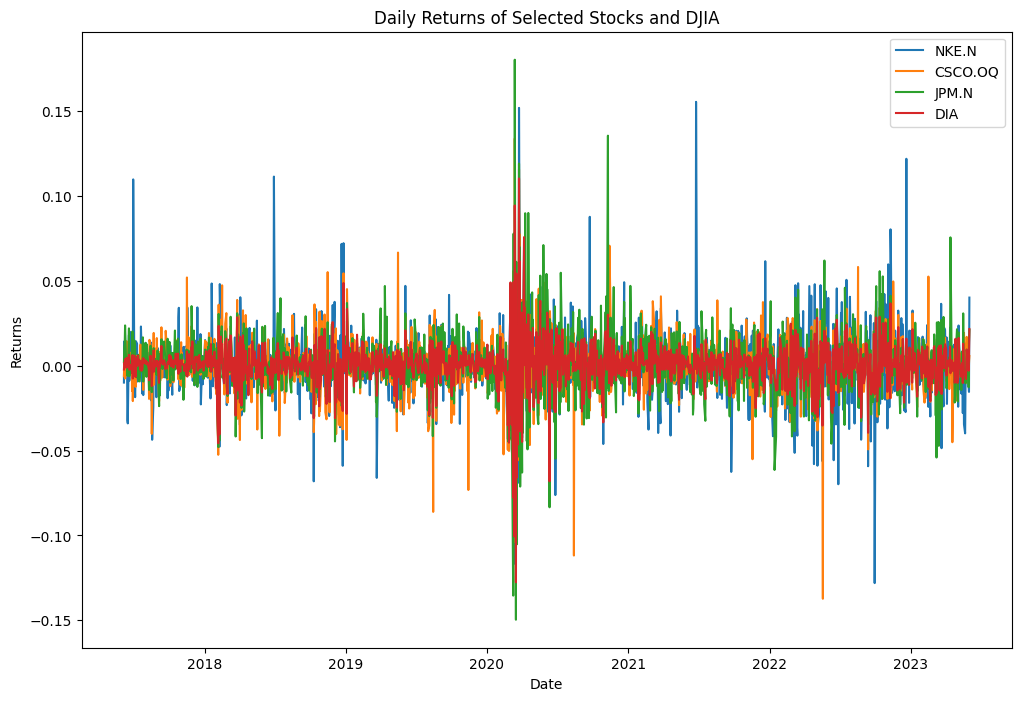


Basic Statistics of Returns:
             NKE.N      CSCO.OQ        JPM.N          DIA
count  1509.000000  1509.000000  1509.000000  1509.000000
mean      0.000673     0.000454     0.000534     0.000392
std       0.020190     0.017446     0.019217     0.012752
min      -0.128081    -0.137304    -0.149649    -0.127612
25%      -0.008800    -0.007396    -0.008145    -0.004387
50%       0.000509     0.000660     0.000131     0.000768
75%       0.010595     0.008482     0.009391     0.005905
max       0.155314     0.133735     0.180125     0.110192


In [70]:
selected_stocks = ['NKE.N','CSCO.OQ','JPM.N', 'DIA']  # DIA is used for DJIA index
data = df[selected_stocks]

# Compute daily returns
returns = data.pct_change().dropna()

# Plot the returns
plt.figure(figsize=(12, 8))
for column in returns.columns:
    plt.plot(returns.index, returns[column], label=column)
plt.legend()
plt.title('Daily Returns of Selected Stocks and DJIA')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

# Basic statistics of the returns
print("\nBasic Statistics of Returns:")
print(returns.describe())

In [71]:
from statsmodels.tsa.api import VAR

In [72]:
# Fit VAR model and select order by BIC
model = VAR(returns)
results = model.fit(maxlags=10, ic='aic')

# Get the optimal lag order
lag_order = results.k_ar
print(f"Optimal lag order (based on AIC): {lag_order}")

# Print summary of the VAR model
print(results.summary())

# Get the coefficient matrices
coef_matrices = results.coefs

Optimal lag order (based on AIC): 8
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 18, Oct, 2024
Time:                     20:52:07
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -34.4777
Nobs:                     1501.00    HQIC:                  -34.7709
Log likelihood:           17838.9    FPE:                6.66203e-16
AIC:                     -34.9450    Det(Omega_mle):     6.10700e-16
--------------------------------------------------------------------
Results for equation NKE.N
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.000756         0.000516            1.467           0.142
L1.NKE.N          -0.024151         0.034762           -0.695           0.487
L1.CSCO.OQ        -0.056369         

### Answer 4.2 Interpretation of VAR model results for NKE.N equation

1. Significant coefficients:
   - L1.JPM.N: -0.130523 (p=0.004) - Negative impact from JPM's 1-day lag
   - L1.DIA: 0.214835 (p=0.023) - Positive impact from DIA's 1-day lag
   - L2.CSCO.OQ: -0.106610 (p=0.014) - Negative impact from CSCO's 2-day lag
   - L8.JPM.N: 0.088789 (p=0.049) - Positive impact from JPM's 8-day lag
   - L8.DIA: -0.369505 (p=0.000) - Strong negative impact from DIA's 8-day lag

2. Most coefficients are not statistically significant at the 5% level.

3. The model suggests some cross-stock dependencies and lagged effects.

4. The constant term (0.000756) is not statistically significant, indicating no consistent trend.

5. The model's overall fit and forecasting performance should be further evaluated.

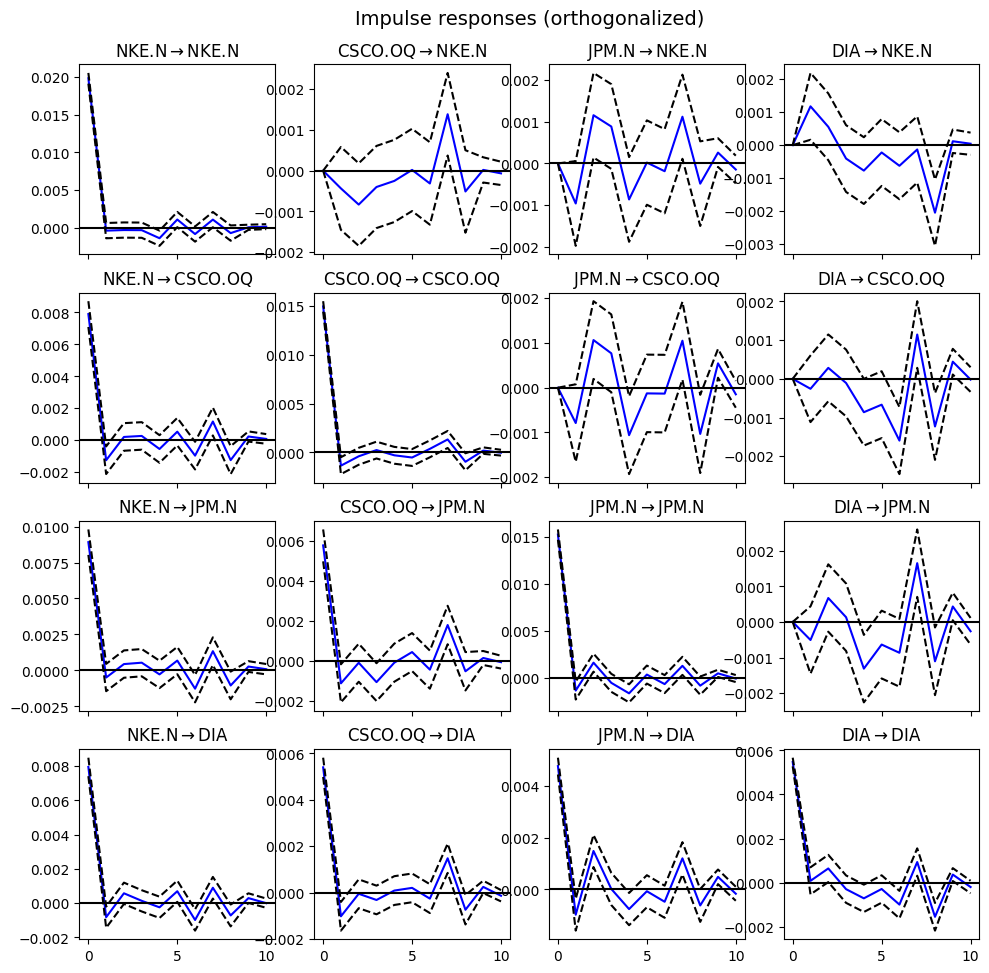

In [73]:
# Perform impulse response analysis
irf = results.irf(periods=10)
irf.plot(orth=True)
plt.show()

### Answer 4.3

Own-stock shocks (on the diagonal) have a strong initial effect, but these impacts quickly diminish, which is typical for return series where shocks tend to be short-lived.
Cross-stock shocks (off-diagonal) generally show limited influence across different stocks, as most of the responses are either close to zero or within the confidence intervals. This suggests that shocks in one stock generally do not spill over significantly to other stocks in this system.

## Appendix - Granger Causality Test

Granger causality is a statistical hypothesis test used to determine whether one time series can be used to predict another. The test is not about "causality" in the strict sense but rather about whether past values of one variable contain information that helps predict future values of another variable. The test evaluates whether the inclusion of the lagged values of one variable (X) improves the forecast accuracy of another variable (Y) beyond the accuracy achievable using only the lagged values of Y itself.

An implementation of the test is available in [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html)

The Granger causality test adds value to the VAR model by explicitly testing whether past values of one variable significantly help predict another, confirming the direction and strength of the influence. While VAR coefficients show how variables are related, the Granger test verifies if those relationships are statistically meaningful for prediction. Together, they provide a clearer picture of which variables truly drive changes in others.

**The Granger Causality Test**

- **Null Hypothesis $H_0$**: Variable X does not Granger-cause Variable Y. This means that past values of X do not provide statistically significant information about the future values of Y.
- **Alternative Hypothesis $H_1$**: Variable X Granger-causes Variable Y. This implies that past values of X provide statistically significant information for predicting Y beyond what is possible with just past values of Y.

**How the Test Works**

The Granger causality test typically involves the following steps:
1. **Model Specification**: A VAR model is specified, incorporating lagged values of both variables (X and Y). The number of lags (determined using criteria such as BIC) is used in the model to capture the dynamic relationship.
2. **Fitting the Model**: The model is estimated with and without including the lagged values of X.
3. **F-Test**: An F-test is conducted to compare the models. If the inclusion of the lagged values of X significantly improves the model for Y (i.e., reduces the residual sum of squares), the null hypothesis is rejected, indicating that X Granger-causes Y.

Interpreting the results can be done through the p-value of the test.

- If the p-value from the test is **less than a chosen significance level** (e.g., 0.05), the null hypothesis $H_0$ is rejected, meaning X Granger-causes Y.
- If the p-value is **greater than** the significance level, there is insufficient evidence to reject the null hypothesis, and we conclude that X does not Granger-cause Y.


To solve the task above:
- Select the lag order determined using AIC for the VAR model.
- For each pair of variables, run the Granger causality test up to the selected lag order.
- Report the p-values for each pair and indicate whether the null hypothesis is rejected or not.
- Discuss the results, identifying which stocks have predictive power over others and what this implies about the interdependencies among the stocks and the DJIA index.



In [74]:
from statsmodels.tsa.stattools import grangercausalitytests

# Define the maximum number of lags to test
max_lag = lag_order  # Use the optimal lag order from your VAR model

# Perform Granger causality tests for each pair of variables
variables = returns.columns

for caused in variables:
    for causing in variables:
        if caused != causing:
            print(f"\nGranger Causality: {causing} -> {caused}")
            granger_test = grangercausalitytests(returns[[caused, causing]], maxlag=max_lag, verbose=False)
            
            # Print p-values for each lag
            for lag, results in granger_test.items():
                print(f"Lag {lag}: p-value = {results[0]['ssr_ftest'][1]:.4f}")



Granger Causality: CSCO.OQ -> NKE.N
Lag 1: p-value = 0.1924
Lag 2: p-value = 0.1876
Lag 3: p-value = 0.2971
Lag 4: p-value = 0.4192
Lag 5: p-value = 0.5485
Lag 6: p-value = 0.4618
Lag 7: p-value = 0.0383
Lag 8: p-value = 0.0682

Granger Causality: JPM.N -> NKE.N
Lag 1: p-value = 0.0050
Lag 2: p-value = 0.0056
Lag 3: p-value = 0.0031
Lag 4: p-value = 0.0014
Lag 5: p-value = 0.0043
Lag 6: p-value = 0.0088
Lag 7: p-value = 0.0004
Lag 8: p-value = 0.0008

Granger Causality: DIA -> NKE.N
Lag 1: p-value = 0.3218
Lag 2: p-value = 0.3893
Lag 3: p-value = 0.4680
Lag 4: p-value = 0.0598
Lag 5: p-value = 0.1456
Lag 6: p-value = 0.0728
Lag 7: p-value = 0.0103
Lag 8: p-value = 0.0007

Granger Causality: NKE.N -> CSCO.OQ
Lag 1: p-value = 0.1436
Lag 2: p-value = 0.1919
Lag 3: p-value = 0.3523
Lag 4: p-value = 0.4288
Lag 5: p-value = 0.3941
Lag 6: p-value = 0.1844
Lag 7: p-value = 0.2544
Lag 8: p-value = 0.2072

Granger Causality: JPM.N -> CSCO.OQ
Lag 1: p-value = 0.0097
Lag 2: p-value = 0.0008
Lag 3

: 

### 4. Granger Causality Analysis

Key Findings:

1. **JPMorgan Chase (JPM.N)** shows strong predictive power over Nike (NKE.N) and Cisco (CSCO.OQ) at all lags.
2. **DJIA (DIA)** strongly predicts Cisco's movements at all lags.
3. **Cisco (CSCO.OQ)** predicts DJIA movements from lag 2 onwards.
4. **Bidirectional relationship** between DJIA and JPMorgan Chase at longer lags.
5. **Nike (NKE.N)** appears more influenced by others than influential itself.

### Implications:

1. **Financial sector** (JPM.N) is a key driver, influencing both individual stocks and the market index.
2. **Technology sector** (CSCO.OQ) plays a crucial role in predicting overall market movements.
3. **Market index** (DIA) has significant influence, especially on tech stocks.
4. **Consumer goods** (NKE.N) seem more reactive to market trends than predictive.
5. Some relationships become significant at longer lags, highlighting the importance of both short-term and long-term analysis.

### Conclusion:

This analysis reveals complex interactions between sectors and the market index. The financial and technology sectors appear particularly influential. These insights can inform investment strategies, but should be considered alongside other analytical tools and market factors.